# Multivariate time-series forecasting with Pytorch LSTMs

- [Tutorial Reference](https://charlieoneill11.github.io/charlieoneill/python/lstm/pytorch/2022/01/14/lstm2.html)

- [Yahoo finance dataset](https://finance.yahoo.com/quote/BTC-USD/history?period1=1502236800&period2=1660003200&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true)

- [PyTorch Dataset and DataLoader](https://www.kaggle.com/code/kishalmandal/pytorch-series-part-1-dataset-and-dataloader)

In [1]:
# Specify GPU to be used-
%env CUDA_DEVICE_ORDER = PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES = 0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
from torch.optim import lr_scheduler
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import pandas as pd
from tqdm import tqdm
from tqdm import trange
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time, os, copy, pickle
from sklearn.preprocessing import StandardScaler, MinMaxScaler

/home/arjun/anaconda3/envs/pytorch-gpu/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
print(f"torch version: {torch.__version__}")

torch version: 1.11.0


In [4]:
# Check if there are multiple devices (i.e., GPU cards)-
print(f"Number of GPU(s) available = {torch.cuda.device_count()}")

# Which GPU Is The Current GPU?
# print(f"current GPU: {torch.cuda.current_device()}")

# Get the name of the current GPU-
# print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")

# Is PyTorch using a GPU?
# print(f"Is PyTorch using a GPU? {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"Current GPU: {torch.cuda.current_device()}")
    print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("PyTorch does not have access to GPU")

Number of GPU(s) available = 1
Current GPU: 0
Current GPU name: NVIDIA GeForce RTX 3080


In [5]:
# Device configuration-
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Available device is {device}')

Available device is cuda


In [6]:
# Read in CSV file-
data = pd.read_csv("BTC-USD.csv")

In [7]:
print(f"Dimensions of dataset: {data.shape}")

Dimensions of dataset: (1827, 7)


In [8]:
# Get data types for all features-
data.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [9]:
print(f"Are there any missing values in dataset? {data.isna().values.any()}")

Are there any missing values in dataset? False


In [10]:
# Convert 'Date' feature to datetime, sort in ascending order
# and reset resulting indices-
data['Date'] = pd.to_datetime(data['Date'])
data.sort_values(by = 'Date', ascending = True, inplace = True)
data.reset_index(drop = True, inplace = True)

In [11]:
# Sanity check-
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-08-09,3420.399902,3422.760010,3247.669922,3342.469971,3342.469971,1468960000
1,2017-08-10,3341.840088,3453.449951,3319.469971,3381.280029,3381.280029,1515110016
2,2017-08-11,3373.820068,3679.719971,3372.120117,3650.620117,3650.620117,2021190016
3,2017-08-12,3650.629883,3949.919922,3613.699951,3884.709961,3884.709961,2219589888
4,2017-08-13,3880.040039,4208.390137,3857.800049,4073.260010,4073.260010,3159089920


In [12]:
print(f"min Date value = {data['Date'].min()} & max value = {data['Date'].max()}")

min Date value = 2017-08-09 00:00:00 & max value = 2022-08-09 00:00:00


In [13]:
# Get basic data statistics-
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1.827000e+03
mean,19416.397674,19921.360465,18849.730833,19424.722149,19424.722149,2.450380e+10
std,17376.407379,17823.080252,16853.925903,17367.955310,17367.955310,2.017131e+10
min,3166.300049,3275.377930,2946.620117,3154.949951,3154.949951,7.680150e+08
25%,7097.275635,7287.041260,6894.411133,7106.541992,7106.541992,7.367460e+09
50%,9936.162109,10191.675781,9694.650391,9951.518555,9951.518555,2.175686e+10
75%,33767.375000,34778.076172,32265.797851,33734.515625,33734.515625,3.440956e+10
max,67549.734375,68789.625000,66382.062500,67566.828125,67566.828125,3.509679e+11


In [13]:
# Compute skew for numerical features:
for col in data.columns.tolist():
    if col == 'Date':
        continue
    else:
        print(f"{col} has {data[col].skew():.4f} skew")

Open has 1.0782 skew
High has 1.0694 skew
Low has 1.0886 skew
Close has 1.0772 skew
Adj Close has 1.0772 skew
Volume has 3.2190 skew


In [14]:
# Compute Pearson's correlation coefficient-
pearson_corr = data.loc[:, ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].corr(method = 'pearson')

In [15]:
# Compute Kendall's correlation coefficient-
kendall_corr = data.loc[:, ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].corr(method = 'kendall')

In [16]:
# Compute Spearman's correlation coefficient-
spearman_corr = data.loc[:, ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].corr(method = 'spearman')

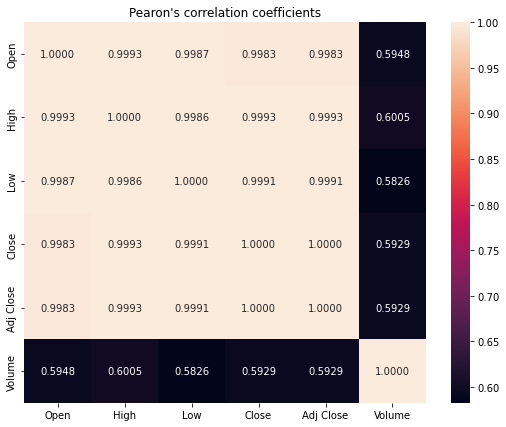

In [17]:
# Visualize correlation matrix as heatmap-
plt.figure(figsize = (9, 7))
sns.heatmap(data = pearson_corr, fmt = '.4f', annot = True)
plt.title("Pearon's correlation coefficients")
plt.show()

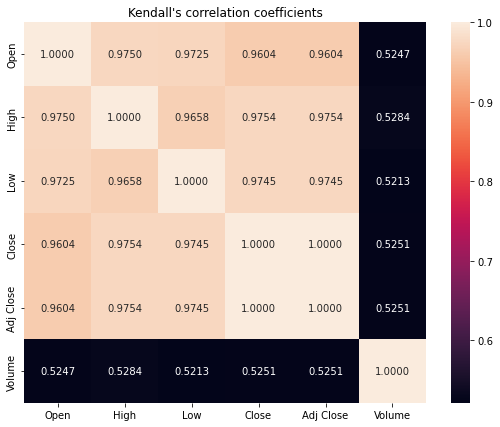

In [18]:
# Visualize correlation matrix as heatmap-
plt.figure(figsize = (9, 7))
sns.heatmap(data = kendall_corr, fmt = '.4f', annot = True)
plt.title("Kendall's correlation coefficients")
plt.show()

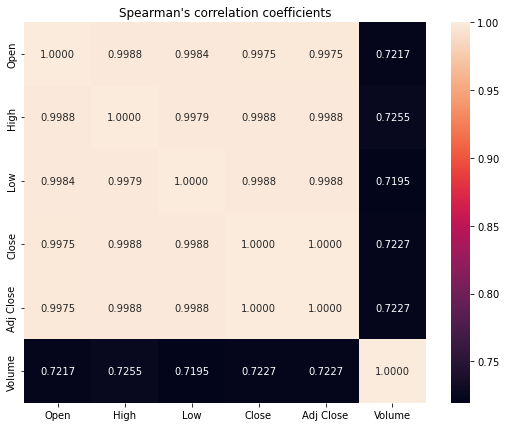

In [19]:
# Visualize correlation matrix as heatmap-
plt.figure(figsize = (9, 7))
sns.heatmap(data = spearman_corr, fmt = '.4f', annot = True)
plt.title("Spearman's correlation coefficients")
plt.show()

In [20]:
# Compute number of bins for histogram distribution-
num_bins = int(np.ceil(np.sqrt(len(data))))
print(f"number of bins using rule of thumb = {num_bins}")

number of bins using rule of thumb = 43


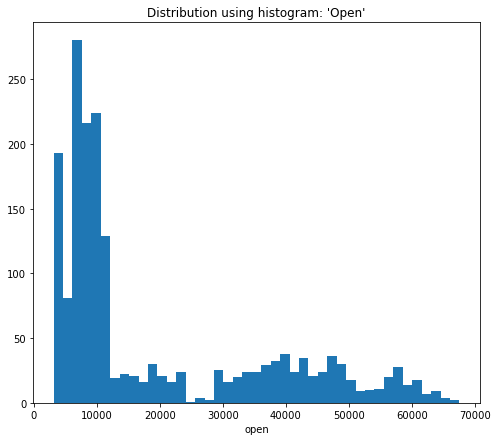

In [21]:
plt.figure(figsize = (8, 7))
n, b, _ = plt.hist(data['Open'], bins = num_bins)
plt.xlabel("open")
plt.title("Distribution using histogram: 'Open'")
plt.show()

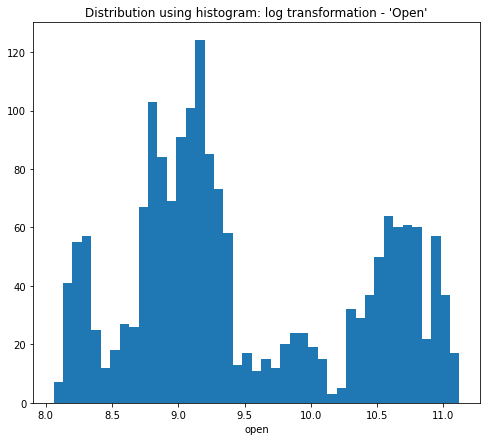

In [22]:
plt.figure(figsize = (8, 7))
n, b, _ = plt.hist(np.log(data['Open']), bins = num_bins)
plt.xlabel("open")
plt.title("Distribution using histogram: log transformation - 'Open'")
plt.show()

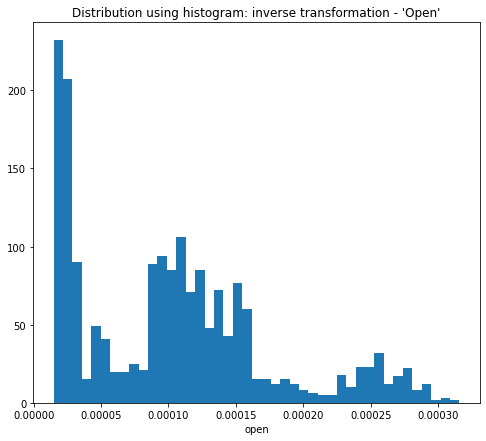

In [23]:
plt.figure(figsize = (8, 7))
n, b, _ = plt.hist(1 / data['Open'], bins = num_bins)
plt.xlabel("open")
plt.title("Distribution using histogram: inverse transformation - 'Open'")
plt.show()

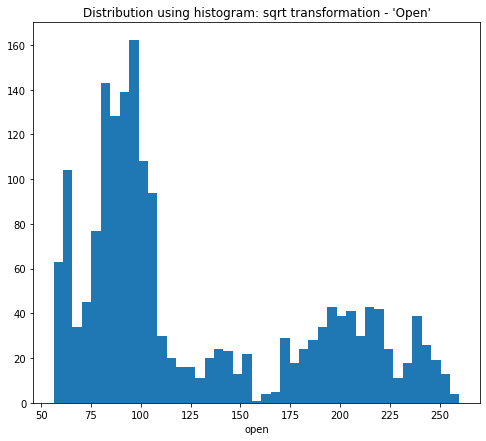

In [24]:
plt.figure(figsize = (8, 7))
n, b, _ = plt.hist(np.sqrt(data['Open']), bins = num_bins)
plt.xlabel("open")
plt.title("Distribution using histogram: sqrt transformation - 'Open'")
plt.show()

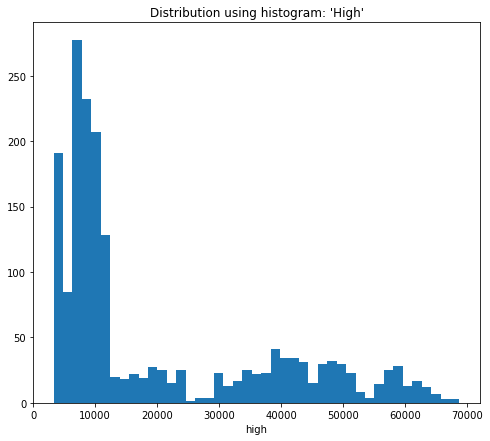

In [25]:
plt.figure(figsize = (8, 7))
n, b, _ = plt.hist(data['High'], bins = num_bins)
plt.xlabel("high")
plt.title("Distribution using histogram: 'High'")
plt.show()

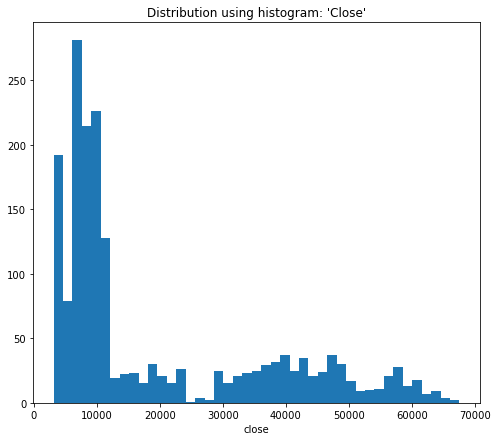

In [26]:
plt.figure(figsize = (8, 7))
n, b, _ = plt.hist(data['Close'], bins = num_bins)
plt.xlabel("close")
plt.title("Distribution using histogram: 'Close'")
plt.show()

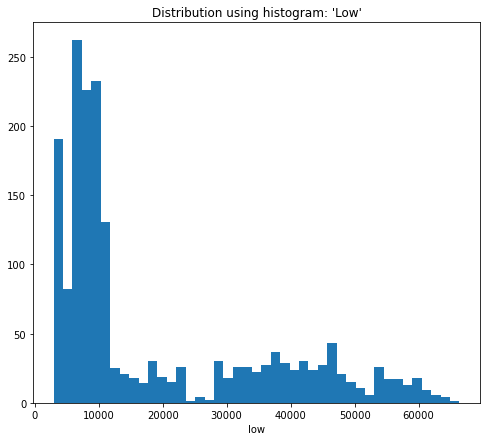

In [27]:
plt.figure(figsize = (8, 7))
n, b, _ = plt.hist(data['Low'], bins = num_bins)
plt.xlabel("low")
plt.title("Distribution using histogram: 'Low'")
plt.show()

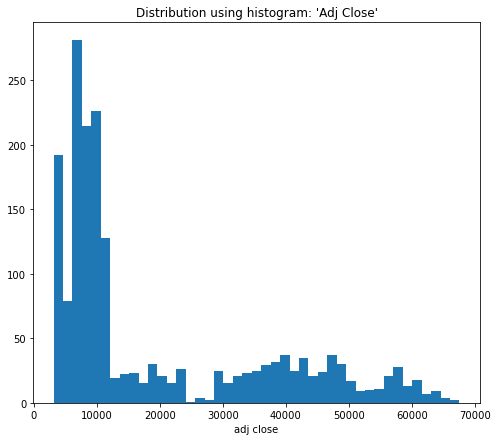

In [28]:
plt.figure(figsize = (8, 7))
n, b, _ = plt.hist(data['Adj Close'], bins = num_bins)
plt.xlabel("adj close")
plt.title("Distribution using histogram: 'Adj Close'")
plt.show()

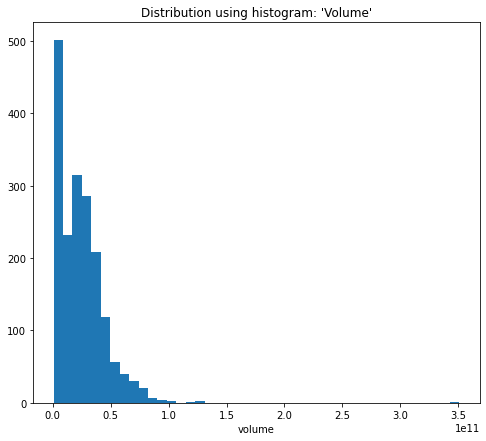

In [29]:
plt.figure(figsize = (8, 7))
n, b, _ = plt.hist(data['Volume'], bins = num_bins)
plt.xlabel("volume")
plt.title("Distribution using histogram: 'Volume'")
plt.show()

In [30]:
# Check for zero or negative values-
data[data.loc[:, 'Volume'] <= 0]

,Date,Open,High,Low,Close,Adj Close,Volume


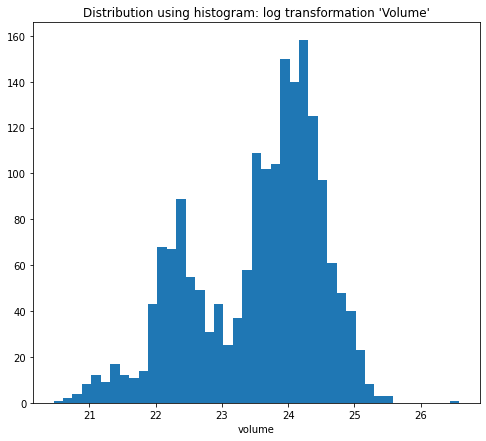

In [31]:
plt.figure(figsize = (8, 7))
n, b, _ = plt.hist(np.log(data['Volume']), bins = num_bins)
plt.xlabel("volume")
plt.title("Distribution using histogram: log transformation 'Volume'")
plt.show()

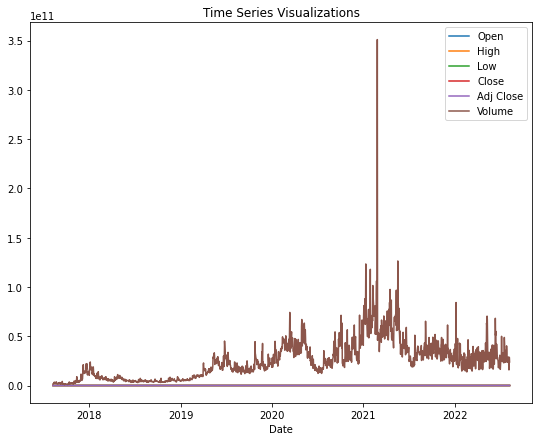

In [32]:
plt.figure(figsize = (9, 7))
plt.plot(data['Date'], data['Open'], label = 'Open')
plt.plot(data['Date'], data['High'], label = 'High')
plt.plot(data['Date'], data['Low'], label = 'Low')
plt.plot(data['Date'], data['Close'], label = 'Close')
plt.plot(data['Date'], data['Adj Close'], label = 'Adj Close')
plt.plot(data['Date'], data['Volume'], label = 'Volume')
plt.xlabel("Date")
plt.title("Time Series Visualizations")
plt.legend(loc = 'best')
plt.show()

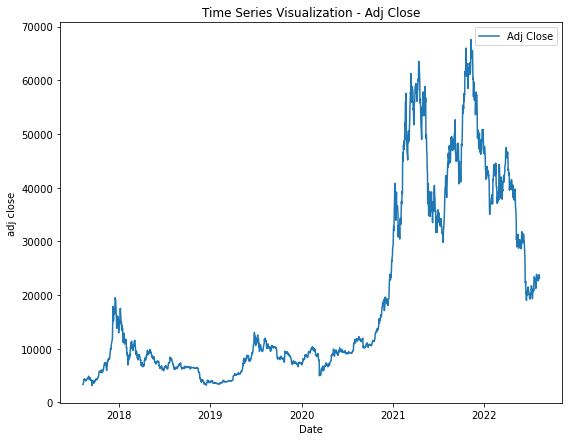

In [33]:
plt.figure(figsize = (9, 7))
plt.plot(data['Date'], data['Adj Close'], label = 'Adj Close')
plt.xlabel("Date")
plt.ylabel("adj close")
plt.title("Time Series Visualization - Adj Close")
plt.legend(loc = 'best')
plt.show()

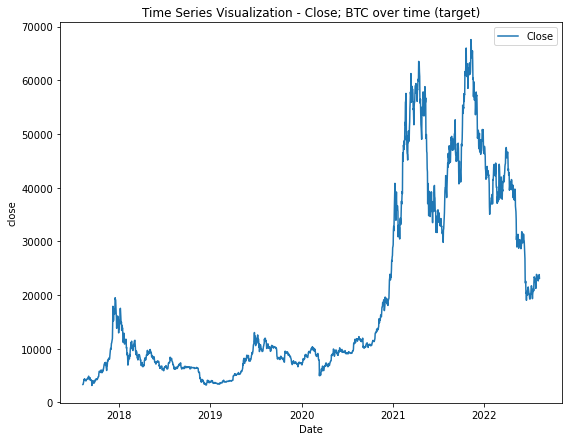

In [34]:
plt.figure(figsize = (9, 7))
plt.plot(data['Date'], data['Close'], label = 'Close')
plt.xlabel("Date")
plt.ylabel("close")
plt.title("Time Series Visualization - Close; BTC over time (target)")
plt.legend(loc = 'best')
plt.show()

#### Further data pre-processing steps

As an example: _regressing the target variable on the features/predictors, and looking for linear relationships between the variables_.

In [14]:
# Remove 'Adj Close' attribute-
data.drop(columns = ['Adj Close'], inplace = True)

In [15]:
# Sanity check-
data.head()

,Date,Open,High,Low,Close,Volume
0,2017-08-09,3420.399902,3422.760010,3247.669922,3342.469971,1468960000
1,2017-08-10,3341.840088,3453.449951,3319.469971,3381.280029,1515110016
2,2017-08-11,3373.820068,3679.719971,3372.120117,3650.620117,2021190016
3,2017-08-12,3650.629883,3949.919922,3613.699951,3884.709961,2219589888
4,2017-08-13,3880.040039,4208.390137,3857.800049,4073.260010,3159089920


In [16]:
# Split into features and target-
X = data.drop(columns = ['Date', 'Close'], axis = 1)
y = data['Close'].values

In [17]:
print(f"Features/predictors has shape: {X.shape} & target has"
      f" shape: {y.shape}")

Features/predictors has shape: (1827, 4) & target has shape: (1827,)


In [18]:
# Scale features and labels-
std_scaler = StandardScaler()
mm_scaler = MinMaxScaler(feature_range = (0, 1))

X_scaled = std_scaler.fit_transform(X)
y_scaled = mm_scaler.fit_transform(y.reshape(-1, 1))

In [19]:
X_scaled.shape, y.shape

((1827, 4), (1827,))

In [20]:
def split_sequences(
    input_sequences, output_sequence,
    n_steps_in, n_steps_out
):
    '''
    Function to convert training data for Seq2Seq neural network
    '''
    X, y = list(), list()
    
    for i in range(len(input_sequences)):
        # find the end of the input, output sequence-
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1
        
        # check if we are beyond the dataset-
        if out_end_ix > len(input_sequences):
            break
            
        # gather input and output of the pattern-
        seq_x, seq_y = input_sequences[i:end_ix], output_sequence[end_ix-1:out_end_ix, -1]
        
        X.append(seq_x), y.append(seq_y)
        
    return np.array(X), np.array(y)


In [21]:
# Generate sequences required for Seq2Seq architecture-
X_seq, y_seq = split_sequences(
    input_sequences = X_scaled, output_sequence = y_scaled,
    n_steps_in = 100, n_steps_out = 50
)

In [22]:
# Sanity check-
X_seq.shape, y_seq.shape

((1679, 100, 4), (1679, 50))

#### Dimension/shape explanation

- The input feature ```X_seq``` is a 3-D tensor having: __(number of training data samples, look back window, number of features)__.

- The output target ```y_seq``` is a 2-D matrix having: __(number of training data samples, look ahead window)__

In [23]:
# Sanity check- Let's check that the first sample in 'y_seq' indeed
# starts at the 100th sample in the original target 'y' vector-
y_seq[0]

array([0.0732278 , 0.07070187, 0.07196188, 0.07578634, 0.07833477,
       0.07632614, 0.07915621, 0.07582173, 0.07915839, 0.08749892,
       0.09587672, 0.10344986, 0.10718287, 0.10454066, 0.10989665,
       0.12141626, 0.12295325, 0.12681279, 0.13199817, 0.13602693,
       0.17289591, 0.22891351, 0.20826051, 0.186662  , 0.19096556,
       0.21396443, 0.22139473, 0.20575785, 0.20817667, 0.22592029,
       0.25371796, 0.24818172, 0.24776873, 0.22700393, 0.20911748,
       0.19636053, 0.16575902, 0.17922549, 0.16721838, 0.1687833 ,
       0.20096992, 0.19691322, 0.17778631, 0.17855791, 0.15210316,
       0.17079847, 0.16304835, 0.18361753, 0.18701597, 0.19319807])

In [24]:
y_scaled[99:149].squeeze(1)

array([0.0732278 , 0.07070187, 0.07196188, 0.07578634, 0.07833477,
       0.07632614, 0.07915621, 0.07582173, 0.07915839, 0.08749892,
       0.09587672, 0.10344986, 0.10718287, 0.10454066, 0.10989665,
       0.12141626, 0.12295325, 0.12681279, 0.13199817, 0.13602693,
       0.17289591, 0.22891351, 0.20826051, 0.186662  , 0.19096556,
       0.21396443, 0.22139473, 0.20575785, 0.20817667, 0.22592029,
       0.25371796, 0.24818172, 0.24776873, 0.22700393, 0.20911748,
       0.19636053, 0.16575902, 0.17922549, 0.16721838, 0.1687833 ,
       0.20096992, 0.19691322, 0.17778631, 0.17855791, 0.15210316,
       0.17079847, 0.16304835, 0.18361753, 0.18701597, 0.19319807])

In [25]:
assert y_seq[0].all() == y_scaled[99:149].squeeze(1).all()

In [26]:
# Get training and testing sets by using 95% as training and 5%
# as testing split-
total_samples = len(X)
train_test_cutoff = round(0.95 * total_samples)

In [27]:
train_test_cutoff, len(X), len(X) - train_test_cutoff

(1736, 1827, 91)

- This gives us a training set size of 1736 days, or about 3 months.
- We will predict for the remaining 91 days into the future, which is almost 3 months.

In [28]:
X_train = X_seq[:-91]
X_test = X_seq[-91:]

y_train = y_seq[:-91]
y_test = y_seq[-91:] 

In [29]:
print(f"X_train.shape: {X_train.shape}, y_train.shape: {y_train.shape}")
print(f"X_test.shape: {X_test.shape}, y_test.shape: {y_test.shape}")

X_train.shape: (1588, 100, 4), y_train.shape: (1588, 50)
X_test.shape: (91, 100, 4), y_test.shape: (91, 50)


In [30]:
# Sanity check-
X_train.shape, y_train.shape

((1588, 100, 4), (1588, 50))

In [31]:
X_test.shape, y_test.shape

((91, 100, 4), (91, 50))

In [32]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        # Convert to torch tensors-
        self.X = torch.tensor(X, dtype = torch.float32)
        self.y = torch.tensor(y, dtype = torch.float32)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        '''
        return {
            'X' : self.X[idx],
            'y' : self.y[idx]
        }
        '''
        return self.X[idx], self.y[idx]
    

In [33]:
# Get train and test datasets-
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [34]:
# Sanity check-
print(f"train_dataset len = {len(train_dataset)} &"
      f" test_dataset len = {len(test_dataset)}")

train_dataset len = 1588 & test_dataset len = 91


In [35]:
# Specify hyper-parameters-
batch_size = 256
num_epochs = 100
learning_rate = 0.001

In [36]:
# Create data loaders-
train_loader = DataLoader(
    dataset = train_dataset, batch_size = batch_size,
    shuffle = False
)

test_loader = DataLoader(
    dataset = test_dataset, batch_size = batch_size,
    shuffle = False
)

In [37]:
print(f"len(train_loader) = {len(train_loader)} &"
      f" len(test_loader) = {len(test_loader)}"
     )

len(train_loader) = 7 & len(test_loader) = 1


In [38]:
# Sanity check-
len(train_dataset) / batch_size, len(test_dataset) / batch_size

(6.203125, 0.35546875)

In [39]:
# Get some batch of data-
features, labels = next(iter(train_loader))

In [40]:
# Sanity check-
features.shape, labels.shape

(torch.Size([256, 100, 4]), torch.Size([256, 50]))

### Seq2Seq using ```LSTM``` RNN

We need to construct the ```LSTM``` class by inheriting from ```nn.Module```. We are going to build this model with the ```nn.LSTM``` rather than ```nn.LSTMCell```. This is because of two reasons:

1. firstly, it's nice to be exposed to both so that we have the option.
1. Secondly, we don't need the flexibility that ```nn.LSTMCell``` provides.

We know that ```nn.LSTM``` is essentially just a recurrent application of ```nn.LSTMCell```. Thus, we would only use ```nn.LSTMCell``` if we wanted to apply other transformation in between different LSTM layers, such as batch-normalisation and dropout. Here however, we can implement dropout automatically using the ```dropout``` parameter in ```nn.LSTM```. We have already standardised our data (see above). Hence, there's not a whole lot of reasons to use the more fiddly ```nn.LSTMCell```.

According to PyTorch's [LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html) documentation, you know that we need to shape the LSTM with input size, hidden size, and number of recurrent layers.

- For example, setting ```num_layers = 2``` would mean stacking two LSTMs together to form a stacked LSTM, with the second LSTM taking in outputs of the first LSTM and computing the final results. Thus, we initialise these three variables in the class's ```__init__``` method.

- __We need to force our model to output only one predicted value, so we also initialise a number of classes variable__.

- Our first layer is obviously a recurrent application of LSTM cells, with all the parameters specified above.

- The output of the ```LSTM``` layer is equal to ```hidden_size``` dimensions, and so, it outputs ```hidden_size``` activations.

In [88]:
# Initialize LSTM layer-
lstm_layer = lstm = nn.LSTM(
    input_size = 4, hidden_size = 128,
    num_layers = 1, batch_first = True,
    dropout = 0, bias = True,
    bidirectional = False
).to(device)

In [87]:
# Initialize stacked LSTM layer-
lstm_stacked_layer = lstm = nn.LSTM(
    input_size = 4, hidden_size = 128,
    num_layers = 2, batch_first = True,
    dropout = 0, bias = True,
    bidirectional = False
).to(device)

In [86]:
features, labels = next(iter(train_loader))
features = features.to(device)
labels = labels.to(device)
features.shape, labels.shape

(torch.Size([256, 100, 4]), torch.Size([256, 50]))

In [89]:
lstm_out, (hn, cn) = lstm_layer(features)

In [90]:
lstm_stacked_out, (hn_s, cn_s) = lstm_stacked_layer(features)

In [91]:
lstm_stacked_out.shape, hn_s.shape, cn_s.shape

(torch.Size([256, 100, 128]),
 torch.Size([2, 256, 128]),
 torch.Size([2, 256, 128]))

In [92]:
lstm_out.shape, hn.shape, cn.shape

(torch.Size([256, 100, 128]),
 torch.Size([1, 256, 128]),
 torch.Size([1, 256, 128]))

In [93]:
print(f"Stacked LSTM layer accepts input shape: {features.shape}, "
      f" outputs shape: {lstm_stacked_out.shape}; hn.shape: {hn_s.shape}"
      f" and cn.shape: {cn_s.shape}"
     )

Stacked LSTM layer accepts input shape: torch.Size([256, 100, 4]),  outputs shape: torch.Size([256, 100, 128]); hn.shape: torch.Size([2, 256, 128]) and cn.shape: torch.Size([2, 256, 128])


In [94]:
print(f"LSTM layer accepts input shape: {features.shape}, "
      f" outputs shape: {lstm_out.shape}; hn.shape: {hn.shape}"
      f" and cn.shape: {cn.shape}"
     )

LSTM layer accepts input shape: torch.Size([256, 100, 4]),  outputs shape: torch.Size([256, 100, 128]); hn.shape: torch.Size([1, 256, 128]) and cn.shape: torch.Size([1, 256, 128])


In [95]:
del lstm_out, lstm_layer, lstm_stacked_out, lstm_stacked_layer, hn, cn

In [47]:
class LSTM(nn.Module):
    
    def __init__(
        self, num_classes,
        input_size, hidden_size,
        num_layers
    ):
        super().__init__()
        
        # Output size-
        self.num_classes = num_classes
        
        # Number of stacked recurrent layers in LSTM-
        self.num_layers = num_layers
        
        # Input size (number of expected features in the input 'x')-
        self.input_size = input_size
        
        # Number of features in the hidden state 'h'-
        self.hidden_size = hidden_size
        
        # bias – If False, then the layer does not use bias weights
        # 'b_ih' and 'b_hh'

        '''
        batch_first – If True, then the input and output tensors are provided as
        (batch, seq, feature) instead of (seq, batch, feature). Note that this does
        not apply to hidden or cell states.
        '''

        '''
        dropout – If non-zero, introduces a Dropout layer on the outputs of each LSTM
        layer except the last layer, with dropout probability equal to dropout.
        '''

        '''
        bidirectional – If True, becomes a bidirectional LSTM.
        '''
        
        # LSTM model-
        if self.num_layers > 1:
            self.lstm = nn.LSTM(
                input_size = input_size, hidden_size = hidden_size,
                num_layers = num_layers, batch_first = True,
                dropout = 0.2, bias = True,
                bidirectional = False
            )
        else:
            self.lstm = nn.LSTM(
                input_size = input_size, hidden_size = hidden_size,
                num_layers = num_layers, batch_first = True,
                dropout = 0, bias = True,
                bidirectional = False
            )
        
        # First fully-connected layer-
        self.fc_1 =  nn.Linear(in_features = hidden_size, out_features = 128)
        
        # Output layer-
        self.fc_2 = nn.Linear(in_features = 128, out_features = num_classes)

        
    def forward(self,x):
        
        # Initialize hidden and cell states as a vector of 0s-
        # hidden state-
        h_0 = Variable(
            torch.zeros(self.num_layers, x.size(0),
                        self.hidden_size, device = x.device)
        )
        
        # cell state-
        c_0 = Variable(
            torch.zeros(
                self.num_layers, x.size(0),
                self.hidden_size, device = x.device)
        )
        
        
        # Propagate input through LSTM-
        
        # LSTM accepts as input: (input, hidden, and internal state)-
        output, (hn, cn) = self.lstm(x, (h_0, c_0))
        output = output.to(device)
        # hn = hn.to(device)
        # cn = cn.to(device)
        
        # Reshape LSTM's output for dense layer-
        out = F.relu(hn.view(-1, self.hidden_size))
        out = F.relu(self.fc_1(out))
        out = self.fc_2(out)
        
        return out
    

In [48]:
# Initialize LSTM Seq2Seq model-
model = LSTM(
    num_classes = 50, input_size = 4,
    hidden_size = 128, num_layers = 1
).to(device)

In [49]:
# Count number of trainable parameters in model-
tot_params = 0

# Print layer names-
for layer in model.state_dict().keys():
    print(f"{layer} has dimension = {model.state_dict()[layer].cpu().detach().numpy().shape}")
    tot_params += model.state_dict()[layer].cpu().numpy().size

lstm.weight_ih_l0 has dimension = (512, 4)
lstm.weight_hh_l0 has dimension = (512, 128)
lstm.bias_ih_l0 has dimension = (512,)
lstm.bias_hh_l0 has dimension = (512,)
fc_1.weight has dimension = (128, 128)
fc_1.bias has dimension = (128,)
fc_2.weight has dimension = (50, 128)
fc_2.bias has dimension = (50,)


In [50]:
print(f"Total number of trainable parameters = {tot_params}")

Total number of trainable parameters = 91570


In [51]:
# Define loss function (MSE for regression)-
loss_criterion = nn.MSELoss()

# Define SGD optimizer-
# optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9)
optimizer = optim.Adam(model.parameters(), lr = 10e-3)

In [96]:
# Initialize stacked LSTM Seq2Seq model-
model_stacked = LSTM(
    num_classes = 50, input_size = 4,
    hidden_size = 128, num_layers = 2
).to(device)

In [98]:
# Make predictions-
out = model_stacked(features)

In [99]:
# Sanity check-
features.shape, labels.shape, out.shape

(torch.Size([256, 100, 4]), torch.Size([256, 50]), torch.Size([512, 50]))

In [104]:
loss_criterion(out[:256, :], labels).cpu().detach().numpy(), loss_criterion(out[256:, :], labels).cpu().detach().numpy()

(array(0.01628028, dtype=float32), array(0.01633039, dtype=float32))

In [ ]:
'''
# Sanity check-
features, labels = next(iter(train_loader))
features.shape, labels.shape

# Move to 'device' (if available)-
features = features.to(device)
labels = labels.to(device)

# Make predictions/forward prop-
out = model(features)

out.shape, labels.shape, features.shape

loss = loss_criterion(out, labels)
print(f"MSE loss = {loss:.4f}")

del features, labels, out
'''

In [52]:
def train_model_progress(model, train_loader):
    '''
    Function to perform one epoch of training by using 'train_loader'.
    Returns loss for this epoch.
    '''
    running_loss = 0.0
    
    model.train()
    
    with tqdm(train_loader, unit = 'batch') as tepoch:
        for features, labels in tepoch:
            tepoch.set_description(f"Training: ")
            
            features = features.to(device)
            labels = labels.to(device)
            
            # Get model predictions-
            outputs = model(features)
            # print(f"labels.shape: {labels.shape}, outputs.shape: {outputs.shape}")
            
            # Compute loss-
            J = loss_criterion(outputs, labels)
            
            # Empty accumulated gradients-
            optimizer.zero_grad()
            
            # Perform backprop-
            J.backward()
            
            # Update parameters-
            optimizer.step()
            
            # global step
            # optimizer.param_groups[0]['lr'] = custom_lr_scheduler.get_lr(step)
            # step += 1
            
            # Compute model's performance statistics-
            running_loss += J.item() * features.size(0)
            
            tepoch.set_postfix(
                loss = running_loss / len(train_dataset),
            )
            
    
    train_loss = running_loss / len(train_dataset)
    
    return train_loss


In [53]:
def test_model_progress(model, test_loader):
    running_loss_val = 0.0

    with torch.no_grad():
        with tqdm(test_loader, unit = 'batch') as tepoch:
            for features, labels in tepoch:
                tepoch.set_description(f"Validation: ")
                
                features = features.to(device)
                labels = labels.to(device)
                
                # Set model to evaluation mode-
                model.eval()
            
                # Predict using trained model-
                outputs = model(features)
                
                # Compute validation loss-
                J_val = loss_criterion(outputs, labels)
                
                running_loss_val += J_val.item() * labels.size(0)
                
                tepoch.set_postfix(
                    val_loss = running_loss_val / len(test_dataset)
                )
            
        
    # return (running_loss_val, correct, total)
    val_loss = running_loss_val / len(test_dataset)

    return val_loss


In [54]:
# Python3 dict to contain metrics-
training_history = {}

In [55]:
# Initialize parameters for saving 'best' models-
loc_patience = 0
best_val_loss = 100

In [56]:
for epoch in range(num_epochs):

    # Train and validate model for 1 epoch-
    train_loss = train_model_progress(model = model, train_loader = train_loader)
    test_loss = test_model_progress(model = model, test_loader = test_loader)
    
    print(f"\nepoch: {epoch + 1} training loss = {train_loss:.4f}, "
          f" & test loss = {test_loss:.4f}\n"
          # f"LR = {optimizer.param_groups[0]['lr']:.4f}\n"
         )
    
    training_history[epoch + 1] = {
        'loss': train_loss, 'test_loss': test_loss
        # 'lr': optimizer.param_groups[0]['lr']
    }

    
    # Save best weights achieved until now-
    if (test_loss < best_val_loss):
        # update 'best_val_loss' variable to lowest loss encountered so far-
        best_val_loss = test_loss

        print(f"Saving model with lowest test_loss = {test_loss:.4f}\n")
        
        # Save trained model with 'best' validation accuracy-
        torch.save(model.state_dict(), "LSTM_BTC_prediction_best_model.pth")
        

Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 309.93batch/s, val_loss=0.0189]



epoch: 1 training loss = 0.0895,  & test loss = 0.0189

Saving model with lowest test_loss = 0.0189



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 303.96batch/s, val_loss=0.0664]



epoch: 2 training loss = 0.0982,  & test loss = 0.0664



Validation: : 100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 371.70batch/s, val_loss=0.118]



epoch: 3 training loss = 0.0306,  & test loss = 0.1175



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 478.91batch/s, val_loss=0.0195]



epoch: 4 training loss = 0.2243,  & test loss = 0.0195



Validation: : 100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 482.38batch/s, val_loss=0.116]



epoch: 5 training loss = 0.1153,  & test loss = 0.1156



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 452.85batch/s, val_loss=0.0947]



epoch: 6 training loss = 0.1024,  & test loss = 0.0947



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 480.56batch/s, val_loss=0.0508]



epoch: 7 training loss = 0.0797,  & test loss = 0.0508



Validation: : 100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 364.18batch/s, val_loss=0.033]



epoch: 8 training loss = 0.0366,  & test loss = 0.0330



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 473.72batch/s, val_loss=0.0666]



epoch: 9 training loss = 0.0322,  & test loss = 0.0666



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 475.11batch/s, val_loss=0.0141]



epoch: 10 training loss = 0.0210,  & test loss = 0.0141

Saving model with lowest test_loss = 0.0141



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 450.81batch/s, val_loss=0.0281]



epoch: 11 training loss = 0.0147,  & test loss = 0.0281



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.51batch/s, val_loss=0.0665]



epoch: 12 training loss = 0.0077,  & test loss = 0.0665



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 489.13batch/s, val_loss=0.0626]



epoch: 13 training loss = 0.0071,  & test loss = 0.0626



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 511.44batch/s, val_loss=0.0393]



epoch: 14 training loss = 0.0060,  & test loss = 0.0393



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 474.25batch/s, val_loss=0.0379]



epoch: 15 training loss = 0.0066,  & test loss = 0.0379



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 455.65batch/s, val_loss=0.0448]



epoch: 16 training loss = 0.0074,  & test loss = 0.0448



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 473.83batch/s, val_loss=0.0466]



epoch: 17 training loss = 0.0063,  & test loss = 0.0466



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 472.01batch/s, val_loss=0.0411]



epoch: 18 training loss = 0.0057,  & test loss = 0.0411



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 472.54batch/s, val_loss=0.0394]



epoch: 19 training loss = 0.0055,  & test loss = 0.0394



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 477.00batch/s, val_loss=0.0411]



epoch: 20 training loss = 0.0053,  & test loss = 0.0411



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 480.56batch/s, val_loss=0.0401]



epoch: 21 training loss = 0.0053,  & test loss = 0.0401



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 480.39batch/s, val_loss=0.0383]



epoch: 22 training loss = 0.0052,  & test loss = 0.0383



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 488.45batch/s, val_loss=0.0383]



epoch: 23 training loss = 0.0052,  & test loss = 0.0383



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 461.42batch/s, val_loss=0.0381]



epoch: 24 training loss = 0.0051,  & test loss = 0.0381



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 451.58batch/s, val_loss=0.0374]



epoch: 25 training loss = 0.0051,  & test loss = 0.0374



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 455.26batch/s, val_loss=0.0371]



epoch: 26 training loss = 0.0050,  & test loss = 0.0371



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 452.02batch/s, val_loss=0.0369]



epoch: 27 training loss = 0.0050,  & test loss = 0.0369



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 453.98batch/s, val_loss=0.0366]



epoch: 28 training loss = 0.0050,  & test loss = 0.0366



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.81batch/s, val_loss=0.0364]



epoch: 29 training loss = 0.0049,  & test loss = 0.0364



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 475.01batch/s, val_loss=0.0363]



epoch: 30 training loss = 0.0049,  & test loss = 0.0363



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 454.77batch/s, val_loss=0.0361]



epoch: 31 training loss = 0.0049,  & test loss = 0.0361



Validation: : 100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 442.25batch/s, val_loss=0.036]



epoch: 32 training loss = 0.0049,  & test loss = 0.0360



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 447.34batch/s, val_loss=0.0359]



epoch: 33 training loss = 0.0048,  & test loss = 0.0359



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 474.52batch/s, val_loss=0.0358]



epoch: 34 training loss = 0.0048,  & test loss = 0.0358



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 473.34batch/s, val_loss=0.0356]



epoch: 35 training loss = 0.0048,  & test loss = 0.0356



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 459.40batch/s, val_loss=0.0356]



epoch: 36 training loss = 0.0048,  & test loss = 0.0356



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 467.44batch/s, val_loss=0.0355]



epoch: 37 training loss = 0.0048,  & test loss = 0.0355



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 485.23batch/s, val_loss=0.0355]



epoch: 38 training loss = 0.0047,  & test loss = 0.0355



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 483.66batch/s, val_loss=0.0354]



epoch: 39 training loss = 0.0047,  & test loss = 0.0354



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 442.16batch/s, val_loss=0.0354]



epoch: 40 training loss = 0.0047,  & test loss = 0.0354



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 477.98batch/s, val_loss=0.0353]



epoch: 41 training loss = 0.0047,  & test loss = 0.0353



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 492.52batch/s, val_loss=0.0354]



epoch: 42 training loss = 0.0047,  & test loss = 0.0354



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 460.05batch/s, val_loss=0.0354]



epoch: 43 training loss = 0.0047,  & test loss = 0.0354



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 472.97batch/s, val_loss=0.0353]



epoch: 44 training loss = 0.0047,  & test loss = 0.0353



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 465.62batch/s, val_loss=0.0354]



epoch: 45 training loss = 0.0047,  & test loss = 0.0354



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 475.76batch/s, val_loss=0.0353]



epoch: 46 training loss = 0.0047,  & test loss = 0.0353



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 453.88batch/s, val_loss=0.0355]



epoch: 47 training loss = 0.0048,  & test loss = 0.0355



Validation: : 100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 437.09batch/s, val_loss=0.035]



epoch: 48 training loss = 0.0048,  & test loss = 0.0350



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 450.76batch/s, val_loss=0.0356]



epoch: 49 training loss = 0.0052,  & test loss = 0.0356



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 439.19batch/s, val_loss=0.0354]



epoch: 50 training loss = 0.0048,  & test loss = 0.0354



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 477.00batch/s, val_loss=0.0358]



epoch: 51 training loss = 0.0054,  & test loss = 0.0358



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 454.57batch/s, val_loss=0.0368]



epoch: 52 training loss = 0.0052,  & test loss = 0.0368



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 480.78batch/s, val_loss=0.0329]



epoch: 53 training loss = 0.0063,  & test loss = 0.0329



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 464.38batch/s, val_loss=0.0434]



epoch: 54 training loss = 0.0061,  & test loss = 0.0434



Validation: : 100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 476.63batch/s, val_loss=0.027]



epoch: 55 training loss = 0.0069,  & test loss = 0.0270



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 497.01batch/s, val_loss=0.0473]



epoch: 56 training loss = 0.0052,  & test loss = 0.0473



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.33batch/s, val_loss=0.0368]



epoch: 57 training loss = 0.0048,  & test loss = 0.0368



Validation: : 100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 432.76batch/s, val_loss=0.037]



epoch: 58 training loss = 0.0049,  & test loss = 0.0370



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 490.22batch/s, val_loss=0.0402]



epoch: 59 training loss = 0.0047,  & test loss = 0.0402



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 474.68batch/s, val_loss=0.0357]



epoch: 60 training loss = 0.0047,  & test loss = 0.0357



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 489.53batch/s, val_loss=0.0381]



epoch: 61 training loss = 0.0046,  & test loss = 0.0381



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 440.62batch/s, val_loss=0.0365]



epoch: 62 training loss = 0.0046,  & test loss = 0.0365



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 461.32batch/s, val_loss=0.0366]



epoch: 63 training loss = 0.0045,  & test loss = 0.0366



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 481.16batch/s, val_loss=0.0367]



epoch: 64 training loss = 0.0045,  & test loss = 0.0367



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 505.34batch/s, val_loss=0.0362]



epoch: 65 training loss = 0.0045,  & test loss = 0.0362



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 438.23batch/s, val_loss=0.0365]



epoch: 66 training loss = 0.0045,  & test loss = 0.0365



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 456.85batch/s, val_loss=0.0363]



epoch: 67 training loss = 0.0045,  & test loss = 0.0363



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 441.97batch/s, val_loss=0.0364]



epoch: 68 training loss = 0.0047,  & test loss = 0.0364



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 489.99batch/s, val_loss=0.0367]



epoch: 69 training loss = 0.0046,  & test loss = 0.0367



Validation: : 100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 463.31batch/s, val_loss=0.036]



epoch: 70 training loss = 0.0050,  & test loss = 0.0360



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 478.91batch/s, val_loss=0.0374]



epoch: 71 training loss = 0.0046,  & test loss = 0.0374



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 474.42batch/s, val_loss=0.0354]



epoch: 72 training loss = 0.0048,  & test loss = 0.0354



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 447.77batch/s, val_loss=0.0375]



epoch: 73 training loss = 0.0046,  & test loss = 0.0375



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 458.85batch/s, val_loss=0.0364]



epoch: 74 training loss = 0.0047,  & test loss = 0.0364



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 475.71batch/s, val_loss=0.0374]



epoch: 75 training loss = 0.0044,  & test loss = 0.0374



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 480.67batch/s, val_loss=0.0367]



epoch: 76 training loss = 0.0044,  & test loss = 0.0367



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 481.55batch/s, val_loss=0.0376]



epoch: 77 training loss = 0.0043,  & test loss = 0.0376



Validation: : 100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 472.65batch/s, val_loss=0.037]



epoch: 78 training loss = 0.0045,  & test loss = 0.0370



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 477.87batch/s, val_loss=0.0374]



epoch: 79 training loss = 0.0045,  & test loss = 0.0374



Validation: : 100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 477.06batch/s, val_loss=0.037]



epoch: 80 training loss = 0.0050,  & test loss = 0.0370



Validation: : 100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 461.27batch/s, val_loss=0.039]



epoch: 81 training loss = 0.0054,  & test loss = 0.0390



Validation: : 100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 470.42batch/s, val_loss=0.032]



epoch: 82 training loss = 0.0071,  & test loss = 0.0320



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 484.11batch/s, val_loss=0.0465]



epoch: 83 training loss = 0.0068,  & test loss = 0.0465



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 440.44batch/s, val_loss=0.0298]



epoch: 84 training loss = 0.0072,  & test loss = 0.0298



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 468.85batch/s, val_loss=0.0478]



epoch: 85 training loss = 0.0058,  & test loss = 0.0478



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 472.60batch/s, val_loss=0.0368]



epoch: 86 training loss = 0.0049,  & test loss = 0.0368



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 449.36batch/s, val_loss=0.0415]



epoch: 87 training loss = 0.0047,  & test loss = 0.0415



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 471.64batch/s, val_loss=0.0387]



epoch: 88 training loss = 0.0045,  & test loss = 0.0387



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 475.71batch/s, val_loss=0.0383]



epoch: 89 training loss = 0.0043,  & test loss = 0.0383



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 481.94batch/s, val_loss=0.0392]



epoch: 90 training loss = 0.0043,  & test loss = 0.0392



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 479.95batch/s, val_loss=0.0376]



epoch: 91 training loss = 0.0043,  & test loss = 0.0376



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 468.48batch/s, val_loss=0.0394]



epoch: 92 training loss = 0.0042,  & test loss = 0.0394



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 440.02batch/s, val_loss=0.0382]



epoch: 93 training loss = 0.0042,  & test loss = 0.0382



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 475.33batch/s, val_loss=0.0396]



epoch: 94 training loss = 0.0041,  & test loss = 0.0396



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 457.59batch/s, val_loss=0.0388]



epoch: 95 training loss = 0.0041,  & test loss = 0.0388



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 479.13batch/s, val_loss=0.0396]



epoch: 96 training loss = 0.0041,  & test loss = 0.0396



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 487.60batch/s, val_loss=0.0391]



epoch: 97 training loss = 0.0041,  & test loss = 0.0391



Validation: : 100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 475.71batch/s, val_loss=0.04]



epoch: 98 training loss = 0.0041,  & test loss = 0.0400



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 448.68batch/s, val_loss=0.0396]



epoch: 99 training loss = 0.0042,  & test loss = 0.0396



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 480.67batch/s, val_loss=0.0398]


epoch: 100 training loss = 0.0043,  & test loss = 0.0398



In [57]:
with open("LSTM_BTC_training_metrics.pkl", "wb") as file:
    pickle.dump(training_history, file)

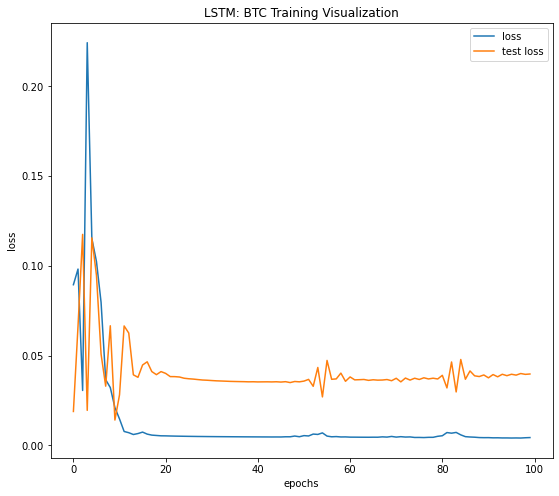

In [58]:
plt.figure(figsize = (9, 8))
plt.plot([training_history[k]['loss'] for k in training_history.keys()], label = 'loss')
plt.plot([training_history[k]['test_loss'] for k in training_history.keys()], label = 'test loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("LSTM: BTC Training Visualization")
plt.legend(loc = 'best')
plt.show()

In [59]:
# Initialize and load 'best' trained parameters from above-
best_model = LSTM(
    num_classes = 50, input_size = 4,
    hidden_size = 128, num_layers = 1
).to(device)
best_model.load_state_dict(torch.load("LSTM_BTC_prediction_best_model.pth"))

<All keys matched successfully>

In [60]:
X_scaled.shape, y_scaled.shape

((1827, 4), (1827, 1))

In [61]:
X_seq.shape, y_seq.shape

((1679, 100, 4), (1679, 50))

In [62]:
# Convert to torch tensors-
X_tensor = Variable(torch.Tensor(X_seq)).to(device)
y_tensor = Variable(torch.Tensor(y_seq)).to(device)

In [63]:
# Reshape for LSTM-
X_tensor = torch.reshape(X_tensor, (X_seq.shape[0], 100, X_seq.shape[2]))

In [64]:
# Sanity check-
X_tensor.shape

torch.Size([1679, 100, 4])

In [65]:
# Get trained model predictions-
predictions = best_model(X_tensor).cpu().detach().numpy()

In [66]:
# Sanity check-
y_tensor.cpu().detach().numpy().shape, predictions.shape

((1679, 50), (1679, 50))

In [67]:
# Reverse Min-Max scaling-
predictions = mm_scaler.inverse_transform(predictions)
y_true = mm_scaler.inverse_transform(y_tensor.cpu().detach().numpy())

In [68]:
predictions.shape, y_true.shape

((1679, 50), (1679, 50))

In [69]:
# Python3 lists to contain values-
preds, true_vals = [], []

In [70]:
for i in range(len(y_true)):
    true_vals.append(y_true[i][0])

In [71]:
for i in range(len(predictions)):
    preds.append(predictions[i][0])

In [72]:
len(true_vals), len(preds)

(1679, 1679)

In [73]:
train_test_cutoff, len(X), len(X) - train_test_cutoff

(1736, 1827, 91)

In [74]:
len(true_vals) - 91

1588

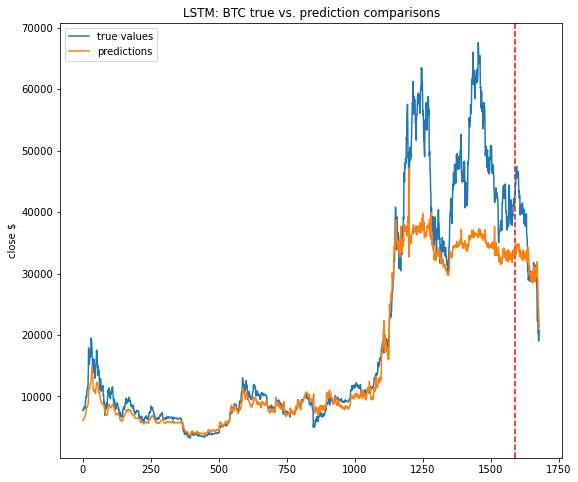

In [75]:
plt.figure(figsize = (9, 8))
plt.axvline(x = len(true_vals) - 91, c = 'r', linestyle = '--')
plt.plot(true_vals, label = 'true values')
plt.plot(preds, label = 'predictions')
plt.title("LSTM: BTC true vs. prediction comparisons")
plt.ylabel("close $")
plt.legend(loc = 'best')
plt.show()

In [77]:
# Compute MSE, MAE and RMSE as metrics-
mse = np.mean(np.square(np.array(true_vals) - np.array(preds)))
mae = np.mean(np.abs(np.array(true_vals) - np.array(preds)))
rmse = np.sqrt(mse)

In [78]:
print(f"MSE = {mse:.4f}, RMSE = {rmse:.4f}, MAE = {mae:.4f}")

MSE = 55176332.0000, RMSE = 7428.0771, MAE = 4091.4712


### LSTM stacked layers architecture resources

- [From LSTMcell to stacked LSTM architecture](https://towardsdatascience.com/from-a-lstm-cell-to-a-multilayer-lstm-network-with-pytorch-2899eb5696f3)

- [PyTorch LSTM tutorial](https://cnvrg.io/pytorch-lstm/)

- [```nn.LSTM``` details](https://torch.mlverse.org/docs/reference/nn_lstm.html)

- [SO](https://stackoverflow.com/questions/49224413/difference-between-1-lstm-with-num-layers-2-and-2-lstms-in-pytorch)
